
Shortest correlation path from AAPL to JPM: ['AAPL', 'JPM']
Total path distance: 1.1680

MST Edges (Top 10):
MA     - V      | dist=0.538 | corr=0.855
AMZN   - META   | dist=0.811 | corr=0.671
AMZN   - MSFT   | dist=0.851 | corr=0.638
KO     - PEP    | dist=0.894 | corr=0.600
AMZN   - GOOGL  | dist=0.930 | corr=0.567
KO     - PG     | dist=0.931 | corr=0.567
MSFT   - NVDA   | dist=0.956 | corr=0.543
AAPL   - AMZN   | dist=0.993 | corr=0.507
JPM    - V      | dist=1.002 | corr=0.498
NVDA   - ORCL   | dist=1.041 | corr=0.458

Top 5 central nodes by degree:
AMZN    5
MA      5
MSFT    3
AAPL    3
V       3
Name: degree, dtype: int64

Top 5 central nodes by betweenness:
MA      0.684211
AMZN    0.578947
AAPL    0.573099
MSFT    0.292398
V       0.292398
Name: betweenness, dtype: float64

Saved files to C:\Users\adity\Downloads\Learn_DSA_Quant\Level-25


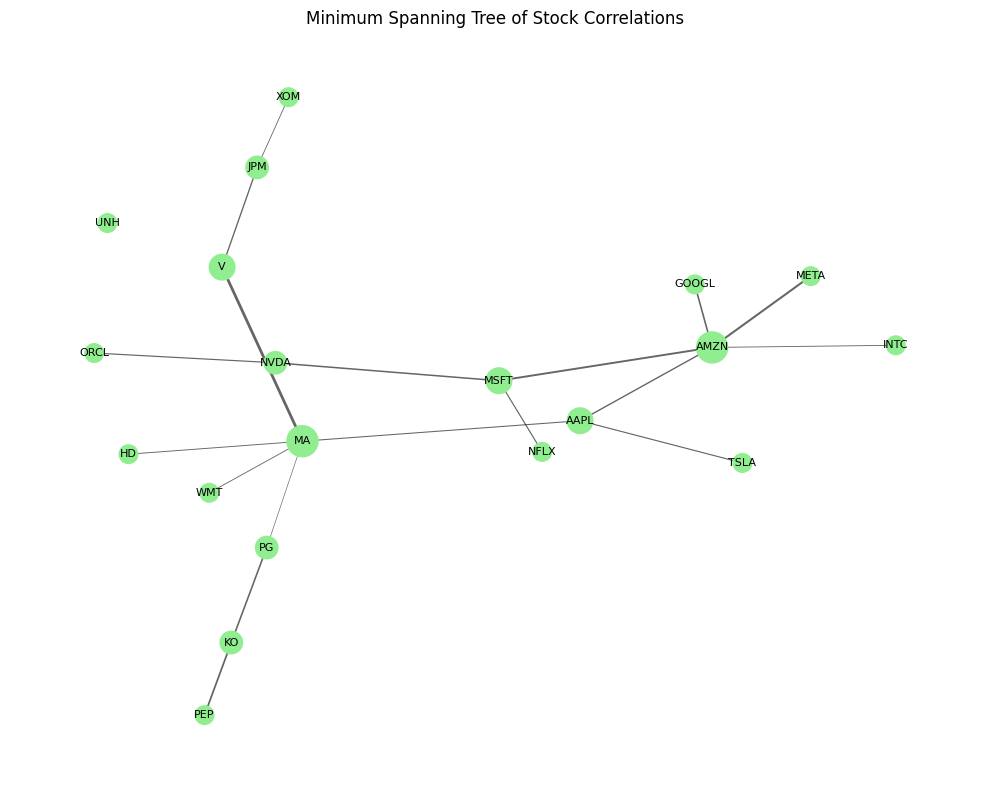

In [1]:
# Step 25 — Dijkstra + Minimum Spanning Tree (MST) for Correlation Networks

import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Parameters ----------------
TICKERS = [
    "AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","JPM","V","MA",
    "UNH","XOM","HD","PG","WMT","KO","PEP","NFLX","ORCL","INTC"
]
LOOKBACK_YEARS = 2
DIST_METHOD = "sqrt"  # distance = sqrt(2*(1-corr))
OUT_DIR = Path(r"C:\Users\adity\Downloads\Learn_DSA_Quant\Level-25")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- Data Load ----------------
def download_prices(tickers, years=2):
    df = yf.download(" ".join(tickers), period=f"{years}y", interval="1d",
                     auto_adjust=True, progress=False, threads=True)
    if isinstance(df.columns, pd.MultiIndex) and "Close" in df.columns.get_level_values(0):
        df = df["Close"]
    elif "Close" in df.columns:
        df = df[["Close"]]
    return df.dropna(how="any")

def make_synthetic(tickers, years=2, seed=25):
    np.random.seed(seed)
    n = years * 252
    dates = pd.bdate_range(end=pd.Timestamp.today().normalize(), periods=n)
    k = 5
    F = np.random.randn(n, k)
    L = np.random.randn(len(tickers), k)
    idio = 0.4 * np.random.randn(n, len(tickers))
    X = F @ L.T + idio
    X = X / X.std(axis=0) * 0.015
    P = 100 * np.exp(np.cumsum(X, axis=0))
    return pd.DataFrame(P, index=dates, columns=tickers)

try:
    px = download_prices(TICKERS, LOOKBACK_YEARS)
    if px.empty: raise ValueError("Empty download")
except Exception:
    print("Using synthetic fallback.")
    px = make_synthetic(TICKERS, LOOKBACK_YEARS)

# ---------------- Compute Distances ----------------
r = px.pct_change().dropna()
C = r.corr()
C = C.fillna(0.0).clip(-1.0, 1.0)

# Convert correlation to distance metric
if DIST_METHOD == "sqrt":
    D = np.sqrt(2 * (1 - C))
else:
    D = 1 - C
np.fill_diagonal(D.values, 0.0)

# ---------------- Build Weighted Graph ----------------
G = nx.Graph()
for i in C.columns:
    for j in C.columns:
        if j <= i: continue
        dist = float(D.loc[i, j])
        G.add_edge(i, j, weight=dist, corr=float(C.loc[i, j]))

# ---------------- Dijkstra Shortest Path ----------------
SOURCE, TARGET = "AAPL", "JPM"
shortest_path = nx.shortest_path(G, source=SOURCE, target=TARGET, weight="weight")
shortest_length = nx.shortest_path_length(G, source=SOURCE, target=TARGET, weight="weight")

print(f"\nShortest correlation path from {SOURCE} to {TARGET}: {shortest_path}")
print(f"Total path distance: {shortest_length:.4f}")

# ---------------- Minimum Spanning Tree (MST) ----------------
mst = nx.minimum_spanning_tree(G, weight="weight", algorithm="kruskal")
edges_mst = sorted(mst.edges(data=True), key=lambda x: x[2]["weight"])

print(f"\nMST Edges (Top 10):")
for (u, v, w) in edges_mst[:10]:
    print(f"{u:6s} - {v:6s} | dist={w['weight']:.3f} | corr={w['corr']:.3f}")

# ---------------- Centrality in MST ----------------
deg_cent = pd.Series(dict(mst.degree()), name="degree").sort_values(ascending=False)
bet_cent = pd.Series(nx.betweenness_centrality(mst, weight="weight"), name="betweenness").sort_values(ascending=False)

print(f"\nTop 5 central nodes by degree:\n{deg_cent.head(5)}")
print(f"\nTop 5 central nodes by betweenness:\n{bet_cent.head(5)}")

# ---------------- Export ----------------
edges_df = pd.DataFrame([
    {"u": u, "v": v, "dist": w["weight"], "corr": w["corr"]}
    for u, v, w in edges_mst
])
edges_df.to_csv(OUT_DIR / "MST_edges.csv", index=False)

centrality_df = pd.concat([deg_cent, bet_cent], axis=1).reset_index().rename(columns={"index":"ticker"})
centrality_df.to_csv(OUT_DIR / "MST_centrality.csv", index=False)

print(f"\nSaved files to {OUT_DIR}")

# ---------------- Visualization ----------------
plt.figure(figsize=(10,8))
pos = nx.spring_layout(mst, seed=42, weight="weight")
weights = np.array([w["corr"] for _,_,w in mst.edges(data=True)])
edge_widths = 2 * (weights - weights.min()) / (weights.max() - weights.min() + 1e-9)
node_sizes = 100 + 80 * np.array([mst.degree(n) for n in mst.nodes()])

nx.draw_networkx_edges(mst, pos, width=edge_widths, alpha=0.6)
nx.draw_networkx_nodes(mst, pos, node_size=node_sizes, node_color='lightgreen')
nx.draw_networkx_labels(mst, pos, font_size=8)
plt.title("Minimum Spanning Tree of Stock Correlations")
plt.axis("off")
plt.tight_layout()
plt.show()
